In [281]:
import pandas as pd
import numpy as np
import os
from importlib import reload
os.chdir("/Users/bytedance/MLTrader-deploy/")
from research.strategies.automl_strategies import *
from research.strategies import strategy_utils
reload(strategy_utils)
DATA_ROOT = "/Users/bytedance/binance_data/csv_data"
bar_window = 240
h5_path = os.path.join(DATA_ROOT, f"dataview_{bar_window}m.h5")
keys = ['Close', 'High', 'Low', 'Open', 'Volume', 'Count', 'timestamp', 'Asset_ID']

In [282]:
adx_window = 14
long_volume_period = 20
left = 6
right = 3

In [283]:
global_dv = {}
for key in keys:
    global_dv[key] = pd.read_hdf(h5_path, key)
    global_dv[key].index = pd.to_datetime(global_dv[key].index, unit="s")

In [284]:
live_days = {}
all_symbols = set(global_dv["Close"].columns)
for symbol in all_symbols:
    symbol_index = global_dv["Close"][symbol].dropna().index
    live_days[symbol] = (symbol_index[-1] - symbol_index[0]).days

In [285]:
live_days = pd.Series(live_days)
live_days.sort_values()

APTUSDT         95
OPUSDT         235
LDOUSDT        258
GALUSDT        262
APEUSDT        311
GMTUSDT        319
PEOPLEUSDT     395
JASMYUSDT      426
GALAUSDT       496
GALABUSD       496
DYDXUSDT       500
FLOWUSDT       541
MASKUSDT       607
CELOUSDT       747
GRTUSDT        766
UNFIUSDT       794
AXSUSDT        809
AAVEUSDT       829
FILUSDT        829
NEARUSDT       830
AVAXUSDT       852
UNIUSDT        857
SUSHIUSDT      873
DOTUSDT        887
CRVUSDT        890
SANDUSDT       891
SOLUSDT        894
YFIUSDT        895
MANAUSDT       899
DOGEBUSD       906
SOLBUSD       1017
BCHUSDT       1151
KAVAUSDT      1185
XRPBUSD       1189
ETHBUSD       1189
BNBBUSD       1221
BTCBUSD       1221
CHZUSDT       1234
DOGEUSDT      1297
ALGOUSDT      1310
FTMUSDT       1321
ATOMUSDT      1364
MATICUSDT     1367
THETAUSDT     1383
ZILUSDT       1433
WAVESUSDT     1465
LINKUSDT      1467
ETCUSDT       1685
TRXUSDT       1686
XLMUSDT       1697
EOSUSDT       1700
XRPUSDT       1724
ADAUSDT     

In [286]:
short_life = set(live_days[live_days < 180].index)
print("short life coins: ", short_life)
all_symbols = all_symbols - short_life

short life coins:  {'APTUSDT'}


In [287]:
" ".join(all_symbols)

'XLMUSDT ZILUSDT SUSHIUSDT GALABUSD ATOMUSDT AVAXUSDT CHZUSDT DYDXUSDT TRXUSDT DOGEUSDT KAVAUSDT CRVUSDT BCHUSDT XRPBUSD FTMUSDT ETHUSDT PEOPLEUSDT AXSUSDT OPUSDT XRPUSDT MATICUSDT SOLBUSD MASKUSDT ADAUSDT GRTUSDT YFIUSDT UNIUSDT GALUSDT FILUSDT GMTUSDT SOLUSDT WAVESUSDT SANDUSDT APEUSDT BTCUSDT FLOWUSDT THETAUSDT UNFIUSDT LTCUSDT EOSUSDT DOTUSDT ETCUSDT ALGOUSDT BNBUSDT LDOUSDT BNBBUSD ETHBUSD GALAUSDT BTCBUSD DOGEBUSD NEARUSDT JASMYUSDT AAVEUSDT MANAUSDT LINKUSDT CELOUSDT'

In [288]:
for key in keys:
    global_dv[key] = global_dv[key][list(all_symbols)]

## 因子构建

In [289]:
# adx
global_dv["adx"] = pd.DataFrame(columns=global_dv["Close"].columns, index=global_dv["Close"].index)
global_dv["minus"] = pd.DataFrame(columns=global_dv["Close"].columns, index=global_dv["Close"].index)
global_dv["plus"] = pd.DataFrame(columns=global_dv["Close"].columns, index=global_dv["Close"].index)
global_dv["pivot_high"] = pd.DataFrame(columns=global_dv["Close"].columns, index=global_dv["Close"].index)
global_dv["pivot_low"] = pd.DataFrame(columns=global_dv["Close"].columns, index=global_dv["Close"].index)
global_dv["volume_adv"] = pd.DataFrame(columns=global_dv["Close"].columns, index=global_dv["Close"].index)
for symbol in all_symbols:
    h = global_dv["High"][symbol].values
    l = global_dv["Low"][symbol].values
    c = global_dv["Close"][symbol].values
    v = global_dv["Volume"][symbol].values
    
    
    plus, minus, adx = calcADX(h, l, c, adx_window)
    global_dv["adx"][symbol] = adx
    global_dv["minus"][symbol] = minus
    global_dv["plus"][symbol] = plus
    
    global_dv["pivot_high"][symbol] = pivot(h, 6, 3, True)
    global_dv["pivot_low"][symbol] = pivot(l, 6, 3, True)
    global_dv["volume_adv"][symbol] = get_volume_advantage(c, v, long_volume_period)

/Users/bytedance/MLTrader-deploy/research/strategies/strategy_utils.py:268: RuntimeWarning: All-NaN slice encountered
  if isHigh and array[i] >= np.nanmax(array[left_bound:right_bound]):


In [317]:
def backtest_return(pos, price, holding_period=1, cost_ret=0.001, precision=2, signal_smoothing=1, rolling_normalize=False, rolling_normalize_window=20):
    pos = pos.round(precision)
    pos = pos.rolling(signal_smoothing).mean()
    if rolling_normalize:
        pos = pos.rolling(rolling_normalize_window).rank(pct=True, ascending=True) * 2 - 1.0
    assert price.shape == pos.shape
    log_ret = np.log(price).diff(holding_period).shift(-holding_period)
    # log_ret = price.pct_change(holding_period).shift(-holding_period)
    log_ret = log_ret.iloc[::holding_period]
    pos = pos.iloc[::holding_period]
    cost = pos.diff(1).abs() * cost_ret
    final_ret = (pos * log_ret - cost * pos.diff(1).abs()).cumsum()
    costless_return = (pos * log_ret).cumsum()
    return final_ret, costless_return

In [291]:
# ma diff
global_dv["ma20"] = global_dv["Close"].rolling(20).mean()
global_dv["ma5"] = global_dv["Close"].rolling(5).mean()
global_dv["std20"] = global_dv["Close"].rolling(20).std()
global_dv["ma_diff"] = global_dv["ma5"] - global_dv["ma20"]

In [292]:
# 动量
three_day = 60 * 24 * 3 // bar_window
one_day = 60 * 24 // bar_window
long_volume_period = 20
volume_ma_window = 40
left = 6
right = 3
# 过滤器
# [0, 1]
global_dv["volume_change"] = (global_dv["Volume"] / global_dv["Volume"].rolling(volume_ma_window).mean()).clip(0, 2)
# 方向指示器
# [-1, 1]
global_dv["pivot_pos"] = (global_dv["Close"] - global_dv["pivot_low"]) / (global_dv["pivot_high"] - global_dv["pivot_low"]) - 0.5
global_dv["pivot_pos"] = global_dv["pivot_pos"].clip(-1, 1)
global_dv["volume_adv_norm"] = (global_dv["volume_adv"] * 2 - 1).clip(-1, 1)
global_dv["directional_adv"] = ((global_dv["plus"] - global_dv["minus"]) / 100 * 2).clip(-1, 1)
global_dv["ma_diff_normalize"] = (global_dv["ma_diff"] / global_dv["std20"]).clip(-1, 1)

<AxesSubplot:>

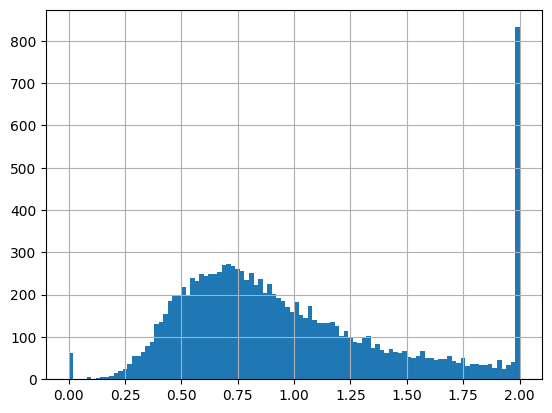

In [293]:
global_dv["volume_change"]["ETHUSDT"].hist(bins=100)

In [294]:
global_dv["volume_adv"]["ETHUSDT"].corr(global_dv["pivot_pos"]["ETHUSDT"])

0.06082660116859468

In [295]:
# ensemble
global_dv["final_signal"] = global_dv["volume_change"] * (global_dv["pivot_pos"] + global_dv["directional_adv"] + global_dv["volume_adv_norm"]) / 3
global_dv["final_signal"] = global_dv["final_signal"].clip(-1, 1)


In [345]:
holding_period = 2
test_SYMBOL = "BTCUSDT"
rolling_normalize = False
rolling_normalize_window = 24
signal_smooth = 1

<AxesSubplot:>

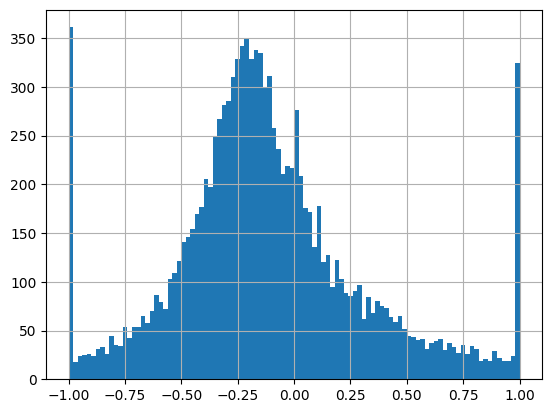

In [346]:
global_dv["final_signal"][test_SYMBOL].hist(bins=100)

# pivot_pos

<AxesSubplot:xlabel='timestamp'>

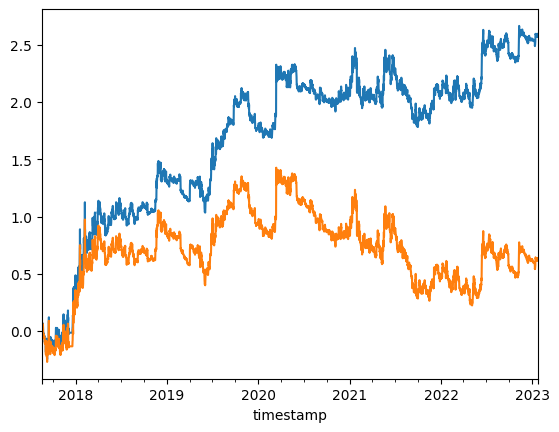

In [347]:
# pivot_pos
bt_return, costless_bt_return = backtest_return(global_dv["pivot_pos"][test_SYMBOL], global_dv["Close"][test_SYMBOL], holding_period=holding_period, rolling_normalize=rolling_normalize, rolling_normalize_window=rolling_normalize_window, signal_smoothing=signal_smooth)
costless_bt_return.plot()
bt_return.plot()

# directional_adv

<AxesSubplot:xlabel='timestamp'>

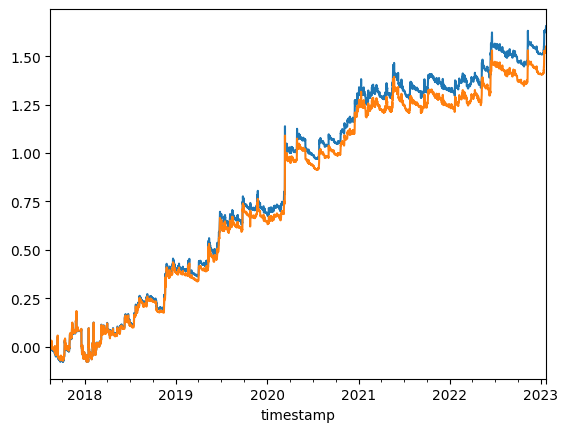

In [348]:
# adv
bt_return, costless_bt_return = backtest_return(global_dv["directional_adv"][test_SYMBOL], global_dv["Close"][test_SYMBOL], holding_period=holding_period, rolling_normalize=rolling_normalize, rolling_normalize_window=rolling_normalize_window, signal_smoothing=signal_smooth)
costless_bt_return.plot()
bt_return.plot()

# volume_adv_norm

<AxesSubplot:xlabel='timestamp'>

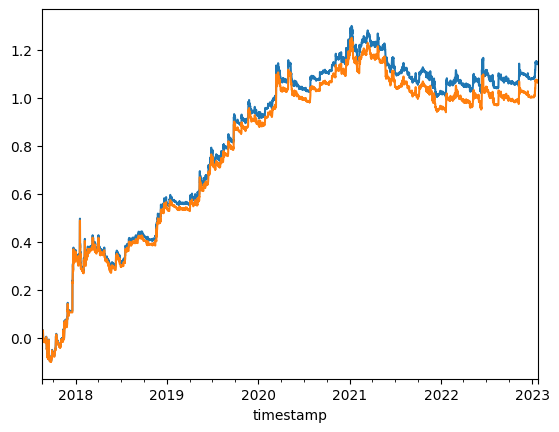

In [349]:
# volume_adv
bt_return, costless_bt_return = backtest_return(global_dv["volume_adv_norm"][test_SYMBOL], global_dv["Close"][test_SYMBOL], holding_period=holding_period, rolling_normalize=rolling_normalize, rolling_normalize_window=rolling_normalize_window, signal_smoothing=signal_smooth)
costless_bt_return.plot()
bt_return.plot()

# ma_diff_normalize

<AxesSubplot:xlabel='timestamp'>

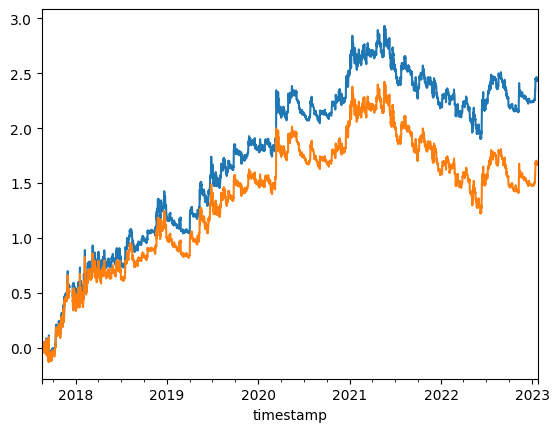

In [350]:
# ma_diff
bt_return, costless_bt_return = backtest_return(global_dv["ma_diff_normalize"][test_SYMBOL], 
                                                global_dv["Close"][test_SYMBOL], 
                                                holding_period=holding_period, 
                                                rolling_normalize=rolling_normalize, 
                                                rolling_normalize_window=rolling_normalize_window, 
                                                signal_smoothing=signal_smooth)
costless_bt_return.plot()
bt_return.plot()

# final score

<AxesSubplot:>

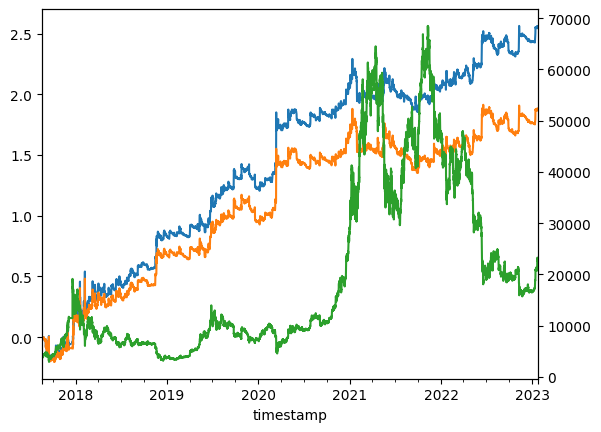

In [351]:
# test_SYMBOL = "BTCUSDT"
bt_return, costless_bt_return = backtest_return(global_dv["final_signal"][test_SYMBOL], 
                                                global_dv["Close"][test_SYMBOL], 
                                                holding_period=holding_period, 
                                                signal_smoothing=signal_smooth, 
                                                rolling_normalize=rolling_normalize, 
                                                rolling_normalize_window=rolling_normalize_window, 
                                                precision=1)
costless_bt_return.plot()
bt_return.plot()
global_dv["Close"][test_SYMBOL].plot(secondary_y=True)

<AxesSubplot:>

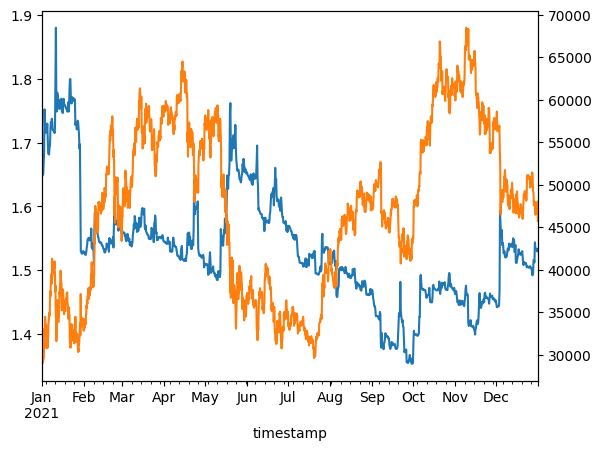

In [352]:
bt_return.loc["2021"].plot()
global_dv["Close"][test_SYMBOL].loc["2021"].plot(secondary_y=True)

<AxesSubplot:>

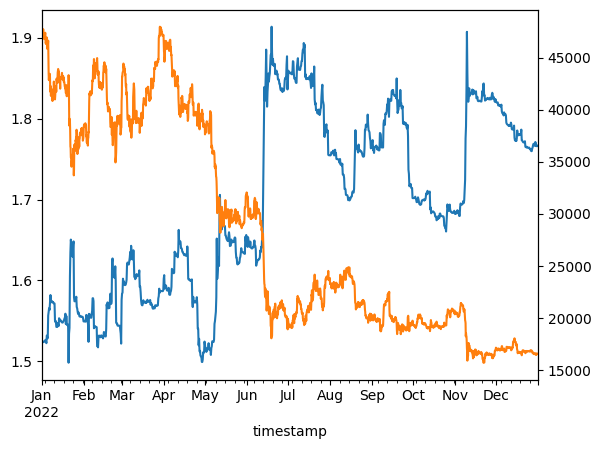

In [353]:
bt_return.loc["2022"].plot()
global_dv["Close"][test_SYMBOL].loc["2022"].plot(secondary_y=True)